<a href="https://colab.research.google.com/github/Rafifoulol/AMIS_Reseau_Neurones/blob/main/MLP_Brain_Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torch.utils.data as data
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import kagglehub
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# Dowload les Data depuis le site Kaggle
path = kagglehub.dataset_download("thomasdubail/brain-tumors-256x256")

BATCH_SIZE = 129
NEW_SIZE = (128, 128)
TYPES= ["Glioma", "Meningioma", "Normal", "Pituitary"]
TRAIN_DATA_PATH = "/root/.cache/kagglehub/datasets/thomasdubail/brain-tumors-256x256/versions/1/Data"
TEST_DATA_PATH = "/content/drive/MyDrive/brain-tumors-256x256/versions/1/DataTest"

3096
500
torch.Size([129, 1, 128, 128])


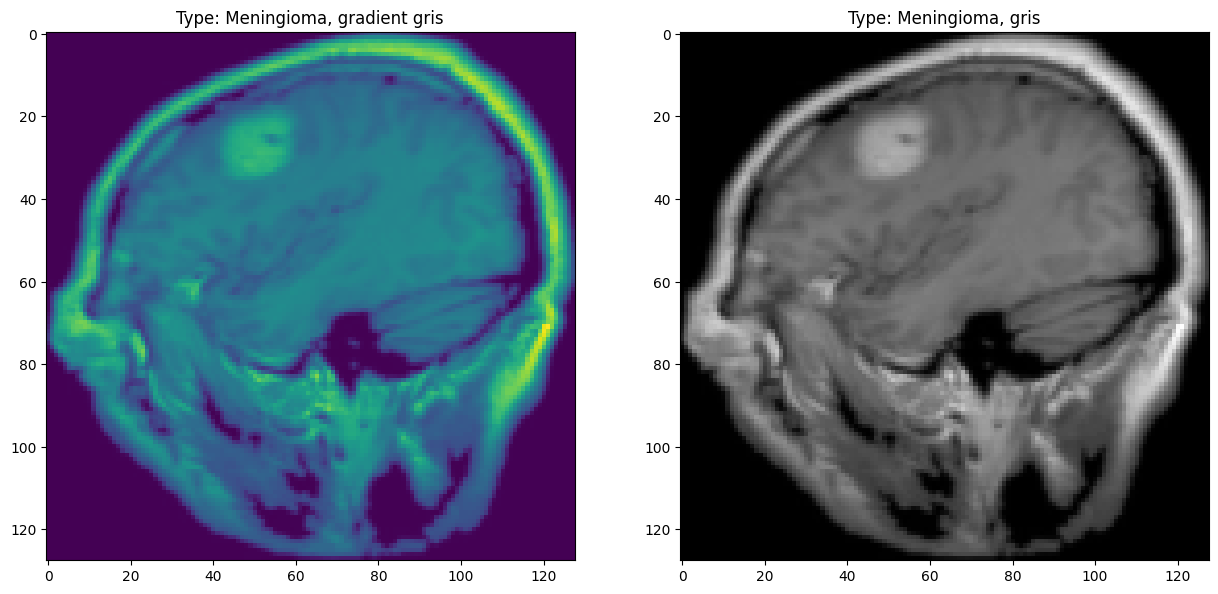

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(NEW_SIZE),
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.ToTensor(),
])

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform)

print(len(train_data))
print(len(test_data))

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

image, label = next(iter(train_data_loader))
print(image.shape)

plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)
plt.imshow(image[0].squeeze())
plt.title(f"Type: {TYPES[label[0]]}, gradient gris")

plt.subplot(1, 2, 2)
plt.imshow(image[0].squeeze(), cmap='gray')
plt.title(f"Type: {TYPES[label[0]]}, gris")
plt.show()

In [ ]:
class MLP(nn.Module) :
  def __init__(self, input_size=16384, output_size=4, layers=[4096, 512]):
    super().__init__()
    self.layers = nn.ModuleList()
    self.layers.append(nn.Linear(input_size, layers[0]))
    self.layers.append(nn.ReLU())
    self.layers.append(nn.Linear(layers[0], layers[1]))
    self.layers.append(nn.ReLU())
    self.layers.append(nn.Linear(layers[1], output_size))

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

In [ ]:
mlp = MLP()
print(mlp.eval())

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=16384, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=4, bias=True)
  )
)


In [ ]:
for images, labels in train_data_loader:
  print(images.shape)
  print(labels.shape)
  break
print("Batch shape after flattening : ", images.view(BATCH_SIZE, -1).size())

torch.Size([129, 1, 128, 128])
torch.Size([129])
Batch shape after flattening :  torch.Size([129, 16384])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
mlp = mlp.to(device)

epochs = 10
train_loses = []
test_loses = []
train_corrects = []
test_corrects = []


train_losses_list = []
test_losses_list = []
train_accuracies_list = []
test_accuracies_list = []

for epoch in range(epochs):
  train_correct = 0
  test_correct = 0

  train_accuracy = 100 * train_correct / len(train_data)
  train_accuracies_list.append(train_accuracy)
  train_losses_list.append(0)

  for b, (images, labels) in enumerate(train_data_loader):
    b += 1

    images = images.to(device)
    labels = labels.to(device)

    y_pred = mlp(images.view(images.size(0), -1))
    loss = criterion(y_pred, labels)

    predicted = torch.max(y_pred.data, 1)[1]
    batch_correct = (predicted == labels).sum()
    train_correct += batch_correct

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_accuracies_list[-1] = 100 * train_correct / len(train_data)
    train_losses_list[-1] = loss.cpu().item()

    #print(f'Epoch [{epoch + 1}/{epochs}], Bach [{b}/{len(train_data_loader)}], '
    #     f'Accuracy: {100 * batch_correct / images.size(0):.2f}%')
  print(f'Epoch [{epoch + 1}/{epochs}], '
        f'Accuracy: {100 * train_correct / len(train_data):.2f}%')
train_loses.append(loss.cpu().item())
train_corrects.append(train_correct.cpu().item())


cuda
Epoch [1/5], Accuracy: 30.65%
Epoch [2/5], Accuracy: 45.51%
Epoch [3/5], Accuracy: 54.68%
Epoch [4/5], Accuracy: 62.92%
Epoch [5/5], Accuracy: 67.99%


In [ ]:
with torch.no_grad():

  test_losses_list = []
  test_accuracies_list = []
  test_correct = 0

  for b, (images, labels) in enumerate(test_data_loader):

    images = images.to(device)
    labels = labels.to(device)

    y_val = mlp(images.view(images.size(0), -1))
    loss = criterion(y_val, labels)
    predicted = torch.max(y_val.data, 1)[1]
    test_correct += (predicted == labels).sum()

    test_accuracies_list.append(100 * (predicted == labels).sum() / images.size(0))
    test_losses_list.append(loss.cpu().item())

    print(f'Testing Bach [{b}/{len(test_data_loader)}], '
          f'Accuracy: {100 * (predicted == labels).sum() / images.size(0):.2f}%, '
          f'Loss: {loss.item():.4f}')

test_loses.append(loss.cpu().item())
test_corrects.append(test_correct.cpu().item())

Testing Bach [0/4], Accuracy: 78.29%, Loss: 0.5762
Testing Bach [1/4], Accuracy: 75.19%, Loss: 0.6316
Testing Bach [2/4], Accuracy: 73.64%, Loss: 0.6423
Testing Bach [3/4], Accuracy: 81.42%, Loss: 0.5902


In [ ]:
train_accuracies_list = [x.cpu() if torch.is_tensor(x) else x for x in train_accuracies_list]
train_losses_list = [x.cpu() if torch.is_tensor(x) else x for x in train_losses_list]
test_accuracies_list = [x.cpu() if torch.is_tensor(x) else x for x in test_accuracies_list]
test_losses_list = [x.cpu() if torch.is_tensor(x) else x for x in test_losses_list]

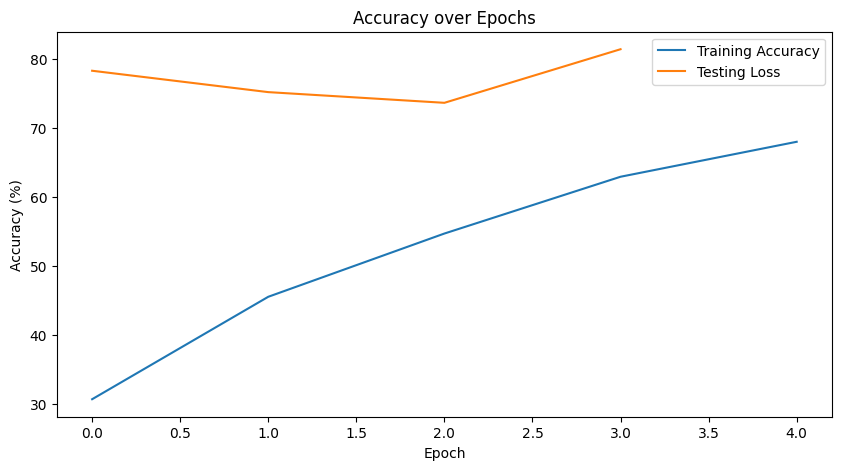

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies_list, label='Training Accuracy')
plt.plot(test_accuracies_list, label='Testing Loss')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

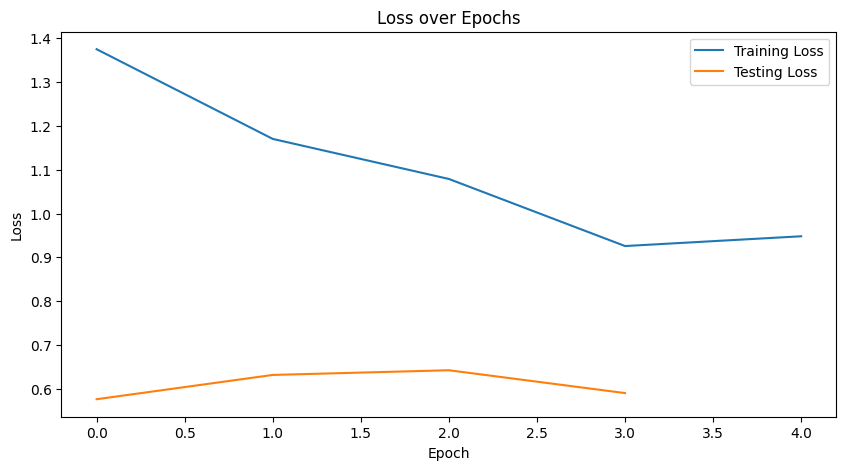

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_list, label='Training Loss')
plt.plot(test_losses_list, label='Testing Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
PATH = "mlp_model.pth"

torch.save(mlp.state_dict(), PATH)

print(f"Model parameters saved to {PATH}")
!ls -la # /content/drive/mlp_model.pth

Model parameters saved to mlp_model.pth
total 270392
drwxr-xr-x 1 root root      4096 Jan  9 14:08 .
drwxr-xr-x 1 root root      4096 Jan  9 12:42 ..
drwxr-xr-x 4 root root      4096 Jan  7 14:21 .config
drwx------ 6 root root      4096 Jan  9 12:46 drive
-rw-r--r-- 1 root root 276853468 Jan  9 14:18 mlp_model.pth
drwxr-xr-x 1 root root      4096 Jan  7 14:22 sample_data


In [ ]:
from google.colab import files
files.download('mlp_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>